In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from utils.log_progress import *
from utils.tools import *
from utils.config import *
from utils.utils import *

from unet.unet import *
from unet.data_generator import *

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from unet.losses import *
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/vgg19_80_20_mlight/unet_vgg19_mlight_dice_0.80017.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

In [151]:
import math

val20_df = pd.read_pickle(Config.DATA_BASE_PATH+'/val_df')
vis_params = {'df':val20_df,
              'input_shape':(512,768,3),
              'pred_layer':1,
              'model':model}

vis = Visualize(**vis_params)

def deprocess_image(img):
    img -= img.mean()
    img /= (img.std()+1e-5)
    img *= 0.1
    
    img += 0.5
    img = np.clip(img,0,1)
    
    return img

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
 
def show_intermediate_layer(n_layer,input_shape=(512,768),cut_x=1,cut_y=1,save=False):
    try:
        n_layer = int(n_layer)
        output_layer = model.layers[n_layer]
    except ValueError:
        output_layer = model.get_layer(str(n_layer))
    
    new_model = Model(input=[model.layers[0].input], output=[output_layer.output])
    activation_shape = output_layer.output_shape[1:3]
    n_kernels = output_layer.output_shape[3]
    n_x = int(math.sqrt(n_kernels))
    n_y = n_kernels // n_x
    
    n_y = n_y//cut_y
    n_x = n_x//cut_x
    
    im = vis.get_image(1002)
    
    activations = new_model.predict(im.reshape(1,*input_shape,3))
    
    shape = (activations.shape[1],activations.shape[2])
    
    print("Number of Kernels: " + str(n_kernels))
    print("Showing: " + str(n_y*n_x))
    kernels = activations[0,:,:,0].reshape(activation_shape)
    kernels = np.zeros((n_y*activation_shape[0],n_x*activation_shape[1]))
    k = 0
    for y in range(n_y):
        for x in range(n_x):
            act = activations[0,:,:,k]
            kernels[y*shape[0]:(y+1)*shape[0],x*shape[1]:(x+1)*shape[1]] = deprocess_image(act)
            #kernels[y*shape[0]:(y+1)*shape[0],x*shape[1]:(x+1)*shape[1]] = act
            k += 1
           
    plt.figure(figsize=(20,20))
    imshow(kernels,cmap="Spectral")
    #plt.colorbar()
    print(output_layer.name)
    plt.title(str(output_layer.name))
    
    if save:
        imsave("layers/"+str(output_layer.name)+".png",kernels,cmap="Spectral",vmin=0.0, vmax=1.0)

In [152]:
model.get_layer("batch_normalization_2")

In [153]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 384, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

Number of Kernels: 1024
Showing: 32
batch_normalization_2


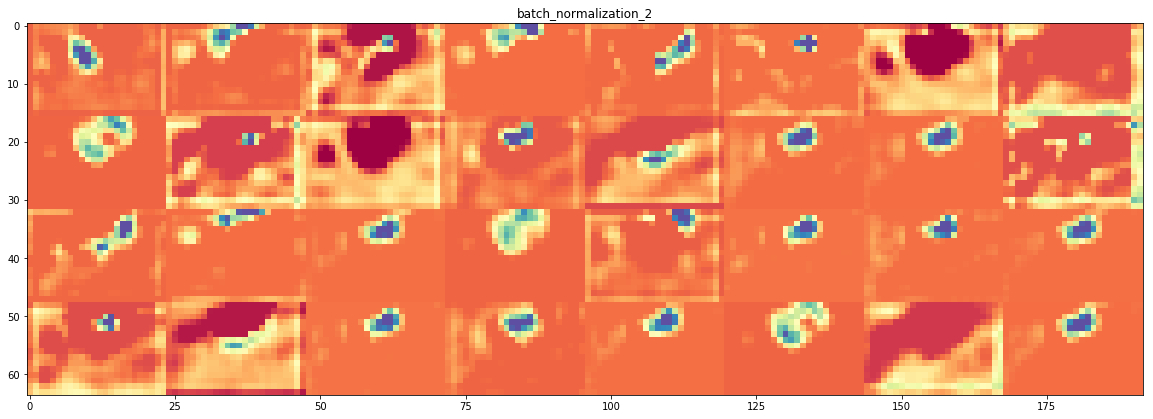

In [157]:
show_intermediate_layer("batch_normalization_2", cut_x=4, cut_y=8, save=True)

Number of Kernels: 64
Showing: 8
block1_conv1


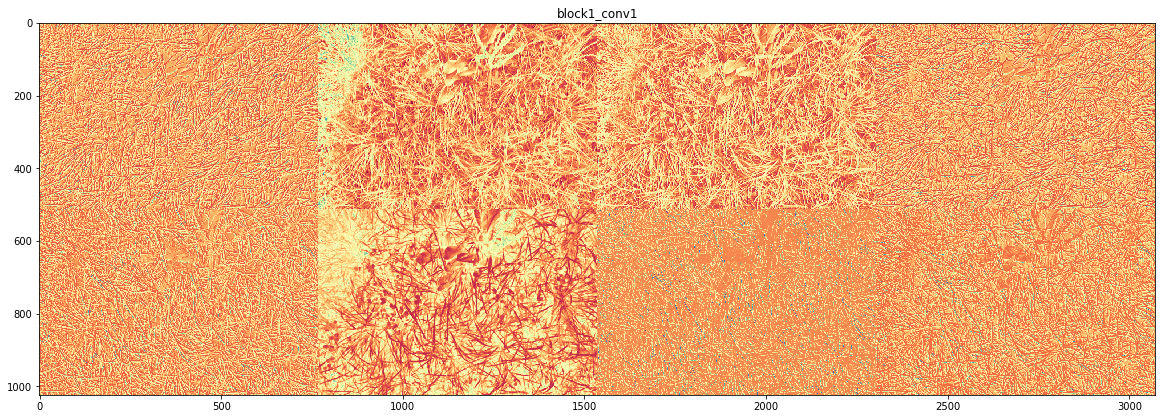

In [155]:
show_intermediate_layer(1, cut_x=2, cut_y=4, save=True)

Number of Kernels: 128
Showing: 5
block2_conv2


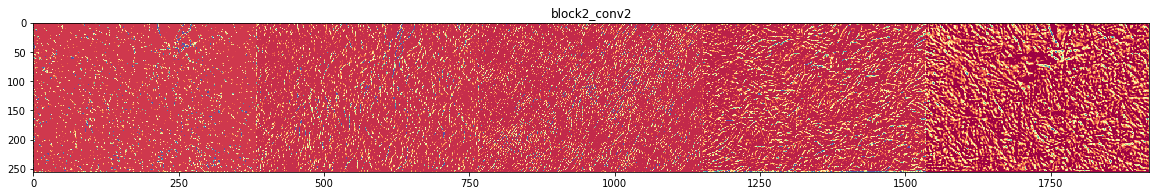

In [113]:
show_intermediate_layer(5, cut_x=2, cut_y=8, save=True)

Number of Kernels: 512
Showing: 22
block4_conv4


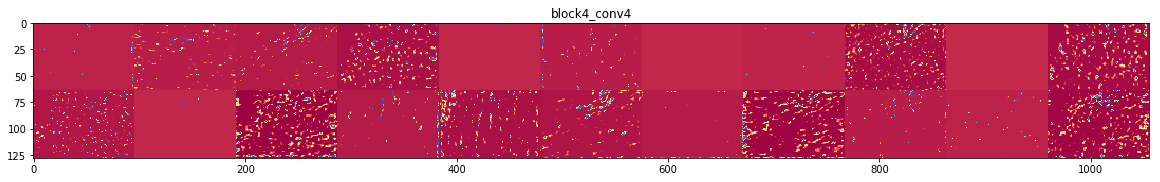

In [104]:
show_intermediate_layer(15,cut_x=2, cut_y=8, save=True)

Number of Kernels: 1024
Showing: 32
conv2d_2


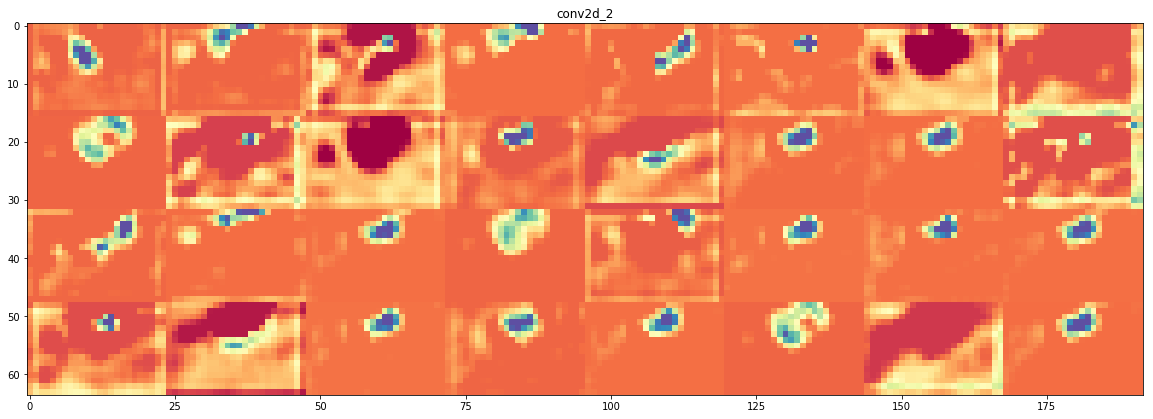

In [105]:
show_intermediate_layer(24,cut_x=4, cut_y=8, save=True)

Number of Kernels: 512
Showing: 10
conv2d_6


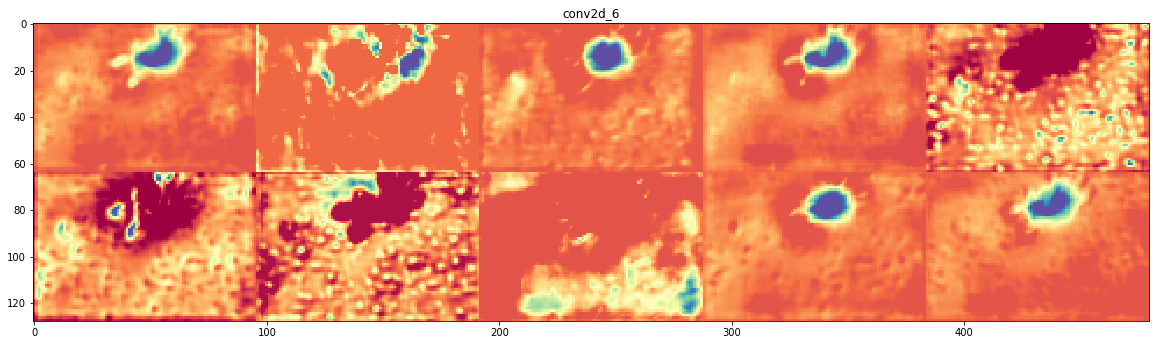

In [106]:
show_intermediate_layer(36,cut_x=4, cut_y=8, save=True)

Number of Kernels: 256
Showing: 4
conv2d_8


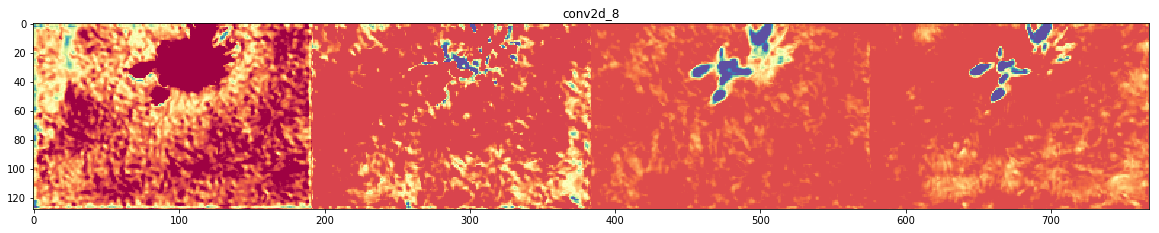

In [107]:
show_intermediate_layer(42,cut_x=4, cut_y=16, save=True)

Number of Kernels: 2
Showing: 2
activation_1


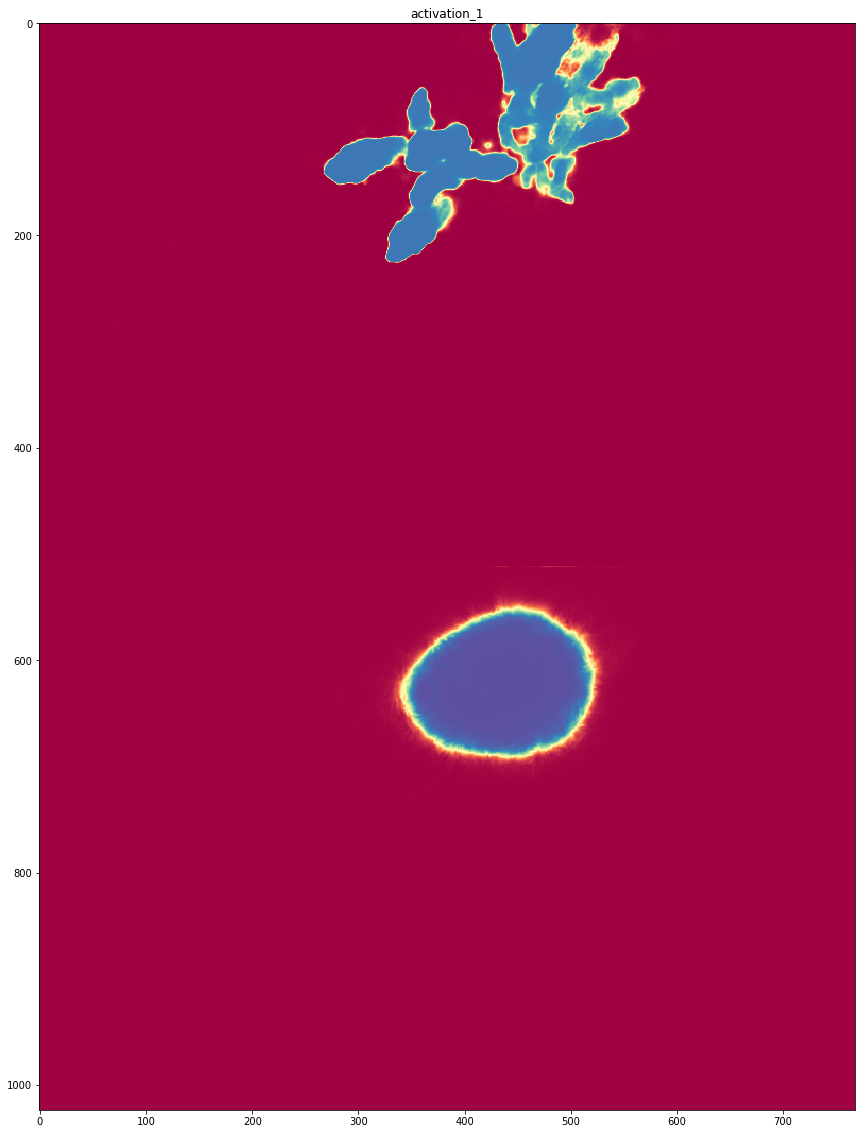

In [108]:
show_intermediate_layer(57, save=True)

In [18]:
import cv2 as cv

def deprocess_image(img):
    img -= img.mean()
    img /= (img.std()+1e-5)
    img *= 0.1
    
    img += 0.5
    img = np.clip(img,0,1)
    return img

def add_median(input_shape=(512,768)):
    int_images_avg = []
    int_images_med = []
    
    font = cv.FONT_HERSHEY_SIMPLEX

    for ind,l in enumerate(model.layers):
        if ind == 0:
            continue
        new_model = Model(input=[model.layers[0].input], output=[model.layers[ind].output])
        activation_shape = model.layers[ind].output_shape[1:3]
        n_kernels = model.layers[ind].output_shape[3]
        n_x = int(math.sqrt(n_kernels))
        n_y = n_kernels // n_x
        activations = new_model.predict(im.reshape(1,*input_shape,3))

        shape = (activations.shape[1],activations.shape[2])
        kernels = activations[0,:,:,0].reshape(activation_shape)
        kernels = np.zeros((n_y*activation_shape[0],n_x*activation_shape[1]))
        
        med = np.median(activations,axis=3).reshape(shape)
        med = resize(med,(512,768))
        med = deprocess_image(med)
        text = np.zeros((50,768))
        text = cv.putText(text, str(model.layers[ind].name), (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
        text = deprocess_image(text)
        med = np.vstack((text,med))
        
        avg = np.mean(activations,axis=3).reshape(shape)
        avg = resize(avg,(512,768))
        avg = deprocess_image(avg)
        text = np.zeros((50,768))
        text = cv.putText(text, str(model.layers[ind].name), (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
        text = deprocess_image(text)
        avg = np.vstack((text,avg))
        
        int_images_med.append(med)
        int_images_avg.append(avg)
        
    return int_images_avg, int_images_med

In [19]:
avg, med = add_median()

In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [21]:
images = avg
def f(x):
    plt.figure(figsize=(10,10))
    imshow(images[x])
interact(f, x=(0,len(images)-1))

interactive(children=(IntSlider(value=28, description='x', max=56), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [54]:
im = vis.get_image(1002)

def save_mean(n_layers,input_shape=(512,768)):
    font = cv.FONT_HERSHEY_SIMPLEX
    for ind,l in enumerate(n_layers):
        new_model = Model(input=[model.layers[0].input], output=[model.layers[l].output])
        activation_shape = model.layers[l].output_shape[1:3]
        n_kernels = model.layers[l].output_shape[3]
        n_x = int(math.sqrt(n_kernels))
        n_y = n_kernels // n_x
        activations = new_model.predict(im.reshape(1,*input_shape,3))

        shape = (activations.shape[1],activations.shape[2])
        kernels = activations[0,:,:,0].reshape(activation_shape)
        kernels = np.zeros((n_y*activation_shape[0],n_x*activation_shape[1]))
        #imshow(np.median(activations,axis=3).reshape(32,48))
        med = np.mean(activations,axis=3).reshape(shape)
        med = resize(med,(512,768))
        med = deprocess_image(med)
        
        text = np.zeros((50,768))
        text = cv.putText(text, str(model.layers[ind].name), (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
        #text /= text.max()
        text = deprocess_image(text)
        med = np.vstack((text,med))
        
        name = "learning/" + str(l) + ".png"
        imsave(name,med,vmin=0.0, vmax=1.0)

In [55]:
save_mean([r for r in range(1,len(model.layers))])

In [67]:
font = cv.FONT_HERSHEY_SIMPLEX

name = "learning/" + "0" + ".png"
text = np.zeros((50,768,3))
text = cv.putText(text, "input image", (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
text = deprocess_image(text)
input_im = im
input_im = np.vstack((text,input_im))
imsave(name,input_im)

pred = model.predict(im.reshape(1,512,768,3))
pred = deprocess_image(pred)

name = "learning/" + "70" + ".png"
text = np.zeros((50,768))
text = cv.putText(text, "prediction mask 0", (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
text = deprocess_image(text)
pred0 = pred[:,:,:,0].reshape(512,768)
pred0 = np.vstack((text,pred0))
imsave(name,pred0,vmin=0.0, vmax=1.0)

name = "learning/" + "80" + ".png"
text = np.zeros((50,768))
text = cv.putText(text, "prediction mask 1", (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
text = deprocess_image(text)
pred1 = pred[:,:,:,1].reshape(512,768)
pred1 = np.vstack((text,pred1))
imsave(name,pred1,vmin=0.0, vmax=1.0)